In [2]:
import numpy as np             
import sounddevice as sd        #importamos sounddevice paquete para la reproduccion y grabacion de audio 
from scipy.io import wavfile    #modulo para lecto-escritura de archivos .wav
import matplotlib.pyplot as plt

In [4]:
from acousticfield.generate import sweep
from acousticfield.process import play_rec, ir_extract

In [5]:
sd.query_devices()

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (Realtek(R) Audio), MME (2 in, 0 out)
   2 Microphone (Logitech BRIO), MME (2 in, 0 out)
   3 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  4 Speakers (Realtek(R) Audio), MME (0 in, 8 out)
   5 S23C350 (NVIDIA High Definition, MME (0 in, 2 out)
   6 Nx Headphones (Waves Virtual Au, MME (0 in, 8 out)
   7 Realtek Digital Output (Realtek, MME (0 in, 2 out)
   8 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   9 Microphone (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  10 Microphone (Logitech BRIO), Windows DirectSound (2 in, 0 out)
  11 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  12 Speakers (Realtek(R) Audio), Windows DirectSound (0 in, 8 out)
  13 S23C350 (NVIDIA High Definition Audio), Windows DirectSound (0 in, 2 out)
  14 Nx Headphones (Waves Virtual Audio Device), Windows DirectSound (0 in, 8 out)
  15 Realtek Digital Output (Realtek(R) Audio), Windows DirectSound

In [6]:
sd.default.device = [2,4]

In [7]:
sweep1 = sweep(T=10.0,fs=48000,f1=30,f2=22000,filename='sweep10s_30_22k')

In [8]:
rec_1 = play_rec('sweep10s_30_22k','rec_L1D1M1') 

listo


In [10]:
ri_1 = ir_extract(rec_1,'sweep10s_30_22k','ri_1')

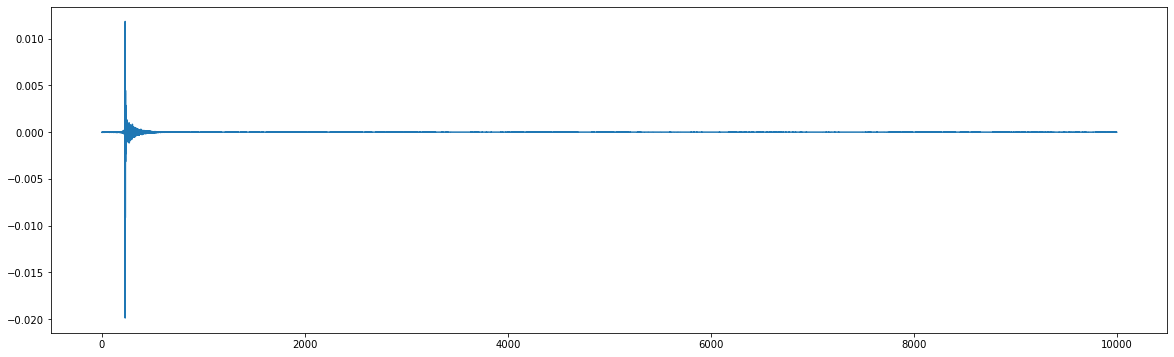

In [11]:
nsamples = len(ri_1)
fs=48000            
t = np.arange(nsamples)/fs*1000   
plt.figure(figsize=(20,6))
plt.plot(t,ri_1,alpha=1)   

In [14]:
import pandas as pd

def pinknoise(nrows, ncols=16):
    """
    Genera ruido rosa usando el algoritmpo de Voss-McCartney, tomado de
    https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb
    nrows: numero de samples a generar
    rcols: numero de fuente indeptes
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)
    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)
    return total.values    

In [39]:
aa = pinknoise(100000)

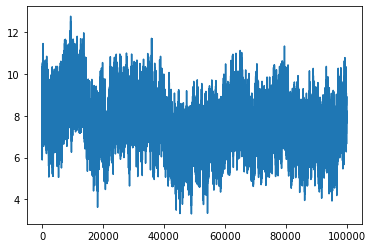

In [40]:
plt.plot(aa)

In [41]:
IPython.display.Audio(aa/13, rate=48000)

In [18]:
def power_noise(nsamples, nchannels, power, fs):
    freqs = np.fft.rfftfreq(nsamples, 1/fs)
    freqs[0] = 1/nsamples
    scaling = (1/(2 * np.pi * freqs))**(power/2)

    real = scaling * np.random.randn(nchannels, freqs.shape[0])
    imag = scaling * np.random.randn(nchannels, freqs.shape[0])

    if not nsamples & 1:
        imag[-1] = 0.
    out = np.array(np.fft.irfft(real + 1j*imag),
                   ndmin=2, dtype='float32').T
    out /= np.abs(out).max(axis=0)
    return out

In [42]:
bb = power_noise(100000, 1, 0, 48000)

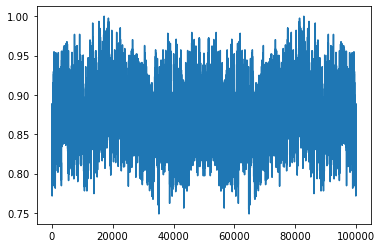

In [36]:
plt.plot(bb)

In [21]:
import IPython


In [43]:
IPython.display.Audio(bb[:,0], rate=48000)

In [46]:
nsamples = 10000
fs = 48000
nchannels = 1
power = 0
freqs = np.fft.rfftfreq(nsamples, 1/fs)
freqs[0] = 1/nsamples
scaling = (1/(2 * np.pi * freqs))**(power/2)

In [51]:
freqs.shape

(5001,)

0.020833333333333332


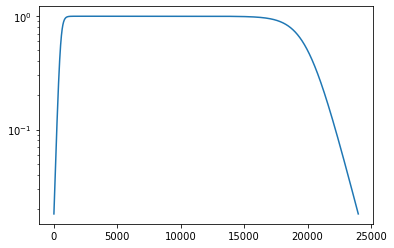

In [173]:
dur = 1
fs = 48000
nsamples = int(fs*dur)
nchannels = 1
freqs = np.fft.rfftfreq(nsamples, 1/fs)
freqs[0] = 1/nsamples
flow = 500
fslope1 = 250
fhigh = 20000
fslope2 = 2000
fmax = freqs[-1]
f1 = np.argmax(freqs>flow)
f2 = np.argmax(freqs>fhigh)
print(flow/fmax)
s1 = sigmoid(freqs/fmax,flow/fmax,fslope1/fmax)
s2 = sigmoid(freqs/fmax,fhigh/fmax,-fslope2/fmax)
s = s1*s2
plt.semilogy(freqs,s)
real = s*np.random.randn(nchannels, freqs.shape[0])
imag = s*np.random.randn(nchannels, freqs.shape[0])


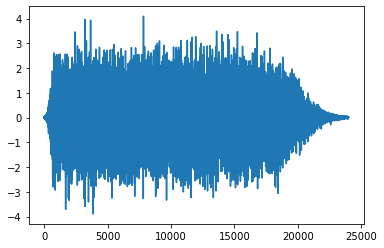

In [174]:
plt.plot(freqs,real.T)

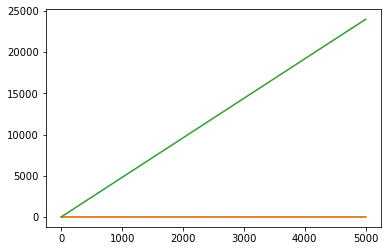

In [57]:
plt.plot(real.T)
plt.plot(imag.T)
plt.plot(freqs)

In [175]:
if not nsamples & 1:
    imag[-1] = 0.
out = np.array(np.fft.irfft(real + 1j*imag),
               ndmin=2, dtype='float32').T
out /= np.abs(out).max(axis=0)

In [84]:
def sigmoid(x,x0=0,a=1):
    x1 = 2*(x-x0)/a
    sig = np.where(x1 < 0, np.exp(x1)/(1 + np.exp(x1)), 1/(1 + np.exp(-x1)))
    return sig

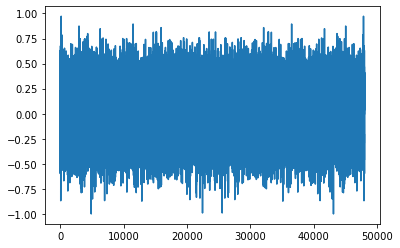

In [176]:
plt.plot(out)
IPython.display.Audio(out[:,0], rate=48000)

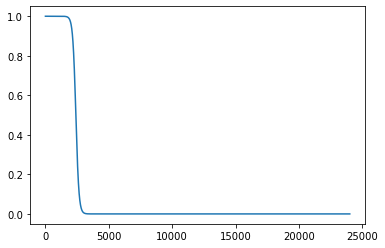

In [90]:
s = sigmoid(freqs/freqs[-1],0.1,-0.01)
plt.plot(freqs,s)

In [121]:
sigmoid(0.000001)

array(0.5000005)

In [192]:
def whitenoise(duration, nchannels, fs, flow=None, fhigh=None, fslow=None, fshigh=None):
    nsamples = int(fs*duration)
    freqs = np.fft.rfftfreq(nsamples, 1/fs)
    freqs[0] = 1/nsamples
    fmax = freqs[-1]
    if flow is not None:
        if fslow is None:
            fslow=flow
        s1 = sigmoid(freqs/fmax,flow/fmax,fslow/fmax)
    else:
        s1 = 1
    if fhigh is not None:
        if fshigh is None:
            fshigh=fshigh/4.0
        s2 = sigmoid(freqs/fmax,fhigh/fmax,-fshigh/fmax)
    else:
        s2 = 1
    real = s1*s2*np.random.randn(nchannels, freqs.shape[0])
    imag = s1*s2*np.random.randn(nchannels, freqs.shape[0])
    if not nsamples & 1:
        imag[-1] = 0.
    out = np.array(np.fft.irfft(real + 1j*imag),
                   ndmin=2, dtype='float32').T
    out /= np.abs(out).max(axis=0)
    return out

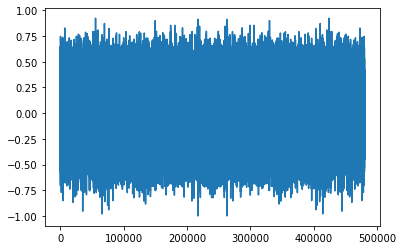

In [195]:
s = whitenoise(10, 1, 48000, 600)
plt.plot(s)
IPython.display.Audio(s.T, rate=48000)

In [194]:
s.shape

(480000, 1)

In [266]:
def pinknoise(T, ncols=16, fs=48000):
    """
    Genera ruido rosa usando el algoritmpo de Voss-McCartney, tomado de
    https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb
    T: duracion en segundos
    rcols: numero de fuente indeptes
    """
    nsamples = int(T*fs)
    array = np.full((nsamples, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nsamples)
    cols = np.random.geometric(0.5, nsamples)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nsamples, size=nsamples)
    array[rows, cols] = np.random.random(nsamples)
    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    pnoise = df.sum(axis=1).values
    pnoise -= np.mean(pnoise)
    pnoise /= np.abs(pnoise).max(axis=0)
    return pnoise

In [279]:
def puretone(T,f,fs=48000):
    return np.sin(2.0*np.pi*f*np.arange(0,T,1/fs))


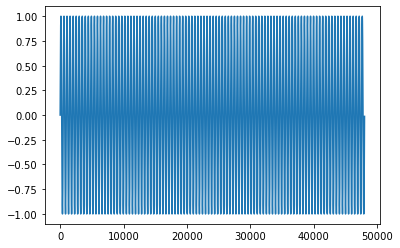

In [280]:
s = puretone(1,100)
plt.plot(s)
IPython.display.Audio(s.T, rate=48000)

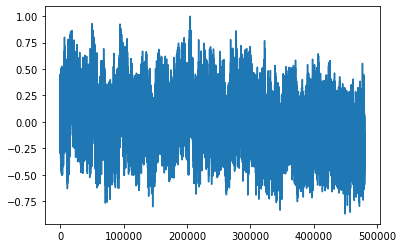

In [272]:
s = pinknoise(10,ncols=100)
plt.plot(s)
IPython.display.Audio(s.T, rate=48000)

In [252]:
fs=48000
T=0.1
ncols=5
#nsamples = int(T*fs)
nsamples = 100
array = np.full((nsamples, ncols), np.nan)
array[0, :] = np.random.random(ncols)
array[:, 0] = np.random.random(nsamples)
cols = np.random.geometric(0.5, nsamples)
cols[cols >= ncols] = 0
rows = np.random.randint(nsamples, size=nsamples)
array[rows, cols] = np.random.random(nsamples)
df = pd.DataFrame(array)
df.fillna(method='ffill', axis=0, inplace=True)

In [253]:
cols

array([4, 3, 1, 2, 2, 1, 1, 2, 4, 4, 2, 4, 2, 1, 2, 2, 1, 2, 1, 1, 2, 4,
       3, 1, 2, 0, 2, 1, 2, 2, 1, 1, 0, 1, 0, 1, 1, 3, 1, 3, 2, 0, 1, 1,
       1, 1, 2, 1, 1, 1, 0, 1, 1, 3, 1, 1, 4, 1, 1, 4, 1, 1, 1, 1, 3, 1,
       1, 2, 1, 1, 3, 1, 1, 1, 4, 0, 1, 1, 3, 1, 3, 0, 1, 1, 2, 2, 0, 3,
       3, 2, 2, 1, 1, 1, 2, 0, 2, 1, 1, 1])

In [254]:
rows

array([50, 56, 87, 83, 50, 83, 38, 50, 53,  1, 13, 62, 34, 65, 35, 33, 86,
       31, 96, 23, 84, 39,  4, 69, 95, 43, 61, 33, 37, 94, 23, 22, 90, 12,
       53, 34, 77, 88, 82, 48,  6, 68, 79, 71, 40, 38, 73, 86, 42, 84, 67,
       40, 41, 72, 30, 67,  5, 45, 42, 83, 59, 61, 21, 47, 79,  2,  6, 30,
       73, 73, 85, 49, 97, 38,  3, 37, 49, 71, 49, 22, 69, 85, 37, 18,  3,
       73, 21, 91,  5, 76, 66, 93, 19, 60,  8, 68, 93, 30, 74, 22])

In [255]:
#array[rows, cols] = np.random.random(nsamples)
df

,0,1,2,3,4
0,0.519147,0.488535,0.908066,0.570837,0.124397
1,0.525754,0.488535,0.908066,0.570837,0.974876
2,0.492603,0.517154,0.908066,0.570837,0.974876
3,0.300771,0.517154,0.249876,0.570837,0.123764
4,0.980915,0.517154,0.249876,0.102135,0.123764
...,...,...,...,...,...
95,0.066127,0.652273,0.916610,0.626012,0.145969
96,0.155794,0.277960,0.916610,0.626012,0.145969
97,0.886156,0.249329,0.916610,0.626012,0.145969
98,0.788680,0.249329,0.916610,0.626012,0.145969


In [240]:
pnoise = np.sum(array,axis=1)

In [241]:
pnoise

array([3.14653588,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

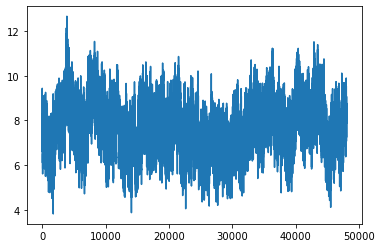

In [212]:
plt.plot(pnoise)

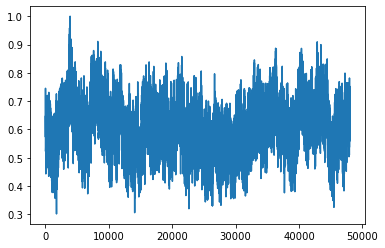

In [213]:
pnoise /= np.abs(pnoise).max(axis=0)
plt.plot(pnoise)